This script loads the images and cells files provided by Genedata and stores the 4-Dimensional blob X for approx 50'000 cells of different phenotypes.

In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import os
import pandas as pd
import os
import dicom
%matplotlib inline

### Background of the files
The data is taken from https://www.broadinstitute.org/bbbc/BBBC022/

* 384 plates. From each well 9 fields are taken with 5 different filters / channels.
    * Image_FileName_OrigER
    * Image_FileName_OrigHoechst
    * Image_FileName_OrigMito
    * Image_FileName_OrigPh_golgi
    * Image_FileName_OrigSyto
    
* An example is `phenoB_PROCAINE_p20594_E24_s9_c5.tif`, which is field s9 and channel c5

Information on the images this information is stored in Images.csv

In [2]:
images = pd.read_csv('/Users/oli/datasets/Genedata/Image.csv')

In [3]:
print(np.shape(images))
pd.DataFrame.head(images)

(873, 292)


,Channel_ER,Channel_Golgi_Actin,Channel_Hoechst,Channel_Mito,Channel_Nucleoli,Count_Cells,Count_Cytoplasm,Count_ExpandedNuclei,Count_GolgiVesicles,Count_Nuclei,...,Threshold_WeightedVariance_GolgiVesicles,Threshold_WeightedVariance_Nuclei,Threshold_WeightedVariance_Nucleoli,URL_ER,URL_Golgi_Actin,URL_Hoechst,URL_Mito,URL_Nucleoli,Unnamed: 290,URL_Cell_Overlay
0,-1,-1,-1,-1,-1,27,27,27,41,27,...,2.440739,0.053885,2.811443,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,NaN,file:///C:/Users/screener/Desktop/BBBC022_Resu...
1,-1,-1,-1,-1,-1,14,14,14,21,14,...,2.273488,0.035032,2.973995,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,NaN,file:///C:/Users/screener/Desktop/BBBC022_Resu...
2,-1,-1,-1,-1,-1,39,39,39,49,39,...,2.546602,0.083277,2.776799,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,NaN,file:///C:/Users/screener/Desktop/BBBC022_Resu...
3,-1,-1,-1,-1,-1,35,35,35,35,35,...,3.640828,0.065690,3.268434,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,NaN,file:///C:/Users/screener/Desktop/BBBC022_Resu...
4,-1,-1,-1,-1,-1,32,32,32,29,32,...,3.694008,0.067800,2.042717,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,file:///C:/Users/screener/Desktop/BBBC022_Prof...,NaN,file:///C:/Users/screener/Desktop/BBBC022_Resu...


## Content of the images files

### The channels
Each line in the `image` file contains a (plate, well, field) combination. The different corresponding channels are referenced in the columns `FileName_xxx` with
* `FileName_Hoechst` for c1
* `FileName_ER` for c2
* `FileName_Nucleoli` for c3
* `FileName_Golgi_Actin` for c4
* `FileName_Mito` for c5

In [4]:
print(images['FileName_Hoechst'][0:3])
print(images['FileName_Nucleoli'][0:3])

0    phenoA_PACLITAXEL_p20585_D19_s1_c1.tif
1    phenoA_PACLITAXEL_p20585_D19_s2_c1.tif
2    phenoA_PACLITAXEL_p20585_D19_s3_c1.tif
Name: FileName_Hoechst, dtype: object
0    phenoA_PACLITAXEL_p20585_D19_s1_c3.tif
1    phenoA_PACLITAXEL_p20585_D19_s2_c3.tif
2    phenoA_PACLITAXEL_p20585_D19_s3_c3.tif
Name: FileName_Nucleoli, dtype: object


## Further stuff in the image file

### The different channels

In [5]:
row = 0
img_FileName_Hoechst = images['FileName_Hoechst'][row]
img_FileName_ER = images['FileName_ER'][row]
img_FileName_Nucleoli = images['FileName_Nucleoli'][row]
img_FileName_Golgi_Actin = images['FileName_Golgi_Actin'][row]
img_FileName_Mito = images['FileName_Mito'][row]
names = (img_FileName_Hoechst,img_FileName_ER,img_FileName_Nucleoli,img_FileName_Golgi_Actin, img_FileName_Mito)

Populating the interactive namespace from numpy and matplotlib
Min=122.0 max=3181.0
Min=163.0 max=3825.0
Min=116.0 max=2230.0
Min=157.0 max=3559.0
Min=179.0 max=3400.0


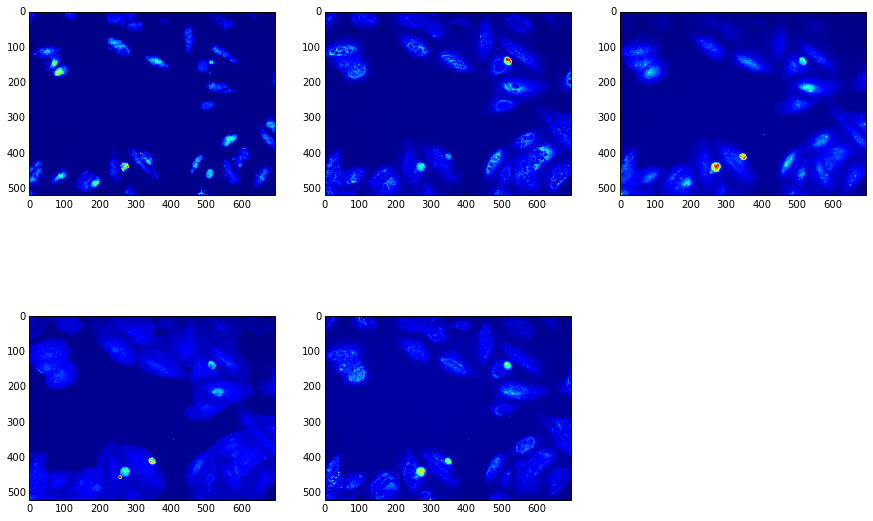

In [6]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15.0, 10.0)
from PIL import Image
from matplotlib.pyplot import imshow

def showImages(row = 0):
    img_FileName_Hoechst = images['FileName_Hoechst'][row]
    img_FileName_ER = images['FileName_ER'][row]
    img_FileName_Nucleoli = images['FileName_Nucleoli'][row]
    img_FileName_Golgi_Actin = images['FileName_Golgi_Actin'][row]
    img_FileName_Mito = images['FileName_Mito'][row]
    names = (img_FileName_Hoechst,img_FileName_ER,img_FileName_Nucleoli,img_FileName_Golgi_Actin, img_FileName_Mito)

    fig = plt.figure()
    for i,name in enumerate(names):
        im = Image.open('/Users/oli/datasets/Genedata/BBBC022_Profiling/' + name)
        im_f = np.asarray(im, dtype='float32')
        print('Min={0} max={1}'.format(np.min(im_f), np.max(im_f)))
        ax = fig.add_subplot(2, 3, i+1)
        ax.imshow(im_f)    
showImages(0)

## The cells files
It seems that the file `Cells.csv` contains all the information of the cells, in the different images. These cell files have been produced with Cellprofiler.

In [7]:
cells = pd.read_csv('/Users/oli/datasets/Genedata/Cells.csv')

In [8]:
pd.DataFrame.head(cells)

,ImageNumber,ObjectNumber,Metadata_Channel,Metadata_Compound,Metadata_FileLocation,Metadata_Frame,Metadata_Phenotype,Metadata_Plate,Metadata_Series,Metadata_Site,...,Texture_Variance_ER_3_0,Texture_Variance_ER_5_0,Texture_Variance_Golgi_Actin_3_0,Texture_Variance_Golgi_Actin_5_0,Texture_Variance_Hoechst_3_0,Texture_Variance_Hoechst_5_0,Texture_Variance_Mito_3_0,Texture_Variance_Mito_5_0,Texture_Variance_Nucleoli_3_0,Texture_Variance_Nucleoli_5_0
0,1,1,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.963408,0.942669,1.432731,1.470543,2.608476,2.653153,1.357492,1.328036,1.516640,1.495042
1,1,2,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.070573,1.084703,1.917686,1.915602,2.261544,2.322472,1.621720,1.628327,1.489087,1.491358
2,1,3,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.703105,0.714262,1.621151,1.623899,1.664106,1.705266,1.610848,1.621337,1.679954,1.700747
3,1,4,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.878495,0.893629,2.028432,2.033459,1.902903,1.943207,1.805773,1.814701,2.316864,2.325391
4,1,5,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.316787,1.330969,1.780373,1.792182,1.583360,1.619792,2.144978,2.150522,2.188546,2.206693


#### Linking the cells with the images
The image number is also for fields, and prob. just the line in the `image` file. **TODO** check.

In [9]:
print(max(cells['ImageNumber']), np.shape(images))

(873, (873, 292))


In [10]:
images['FileName_ER'][873-1]

'phenoA_OXIBENDAZOLE_p20646_K14_s9_c2.tif'

#### Infereing the phenotype

In [11]:
pheno = cells['Metadata_Phenotype']
np.shape(pheno)

(61491,)

In [12]:
np.histogram(pheno, bins=[0, 1, 2, 3,4,5,6])

(array([47052,  2423, 11545,   471,     0,     0]),
 array([0, 1, 2, 3, 4, 5, 6]))

In [112]:
cells[pheno == 3][0:4]

,ImageNumber,ObjectNumber,Metadata_Channel,Metadata_Compound,Metadata_FileLocation,Metadata_Frame,Metadata_Phenotype,Metadata_Plate,Metadata_Series,Metadata_Site,...,Texture_Variance_ER_3_0,Texture_Variance_ER_5_0,Texture_Variance_Golgi_Actin_3_0,Texture_Variance_Golgi_Actin_5_0,Texture_Variance_Hoechst_3_0,Texture_Variance_Hoechst_5_0,Texture_Variance_Mito_3_0,Texture_Variance_Mito_5_0,Texture_Variance_Nucleoli_3_0,Texture_Variance_Nucleoli_5_0
7648,100,1,NaN,DIGOXIN,NaN,0,3,20589,0,1,...,1.383539,1.405770,2.893038,2.913531,3.016234,3.099084,0.409219,0.420427,2.372389,2.394501
7649,100,2,NaN,DIGOXIN,NaN,0,3,20589,0,1,...,4.637667,4.672068,4.107665,3.998264,4.375605,4.535656,2.061702,2.137286,4.705071,4.577923
7650,101,1,NaN,DIGOXIN,NaN,0,3,20589,0,2,...,2.568051,2.621451,1.736279,1.756672,4.204163,4.358405,1.069456,1.120307,2.513340,2.536509
7651,101,2,NaN,DIGOXIN,NaN,0,3,20589,0,2,...,1.015815,0.912146,2.868172,2.880401,4.988809,5.134689,0.952053,0.907609,1.888000,1.760464


### Biological Meaning of the phenotypes

* 0 Metadata_Compound = 'DMSO'
* 1 PACLITAXEL https://de.wikipedia.org/wiki/Paclitaxel
* 2 METOCLOPRAMIDE https://de.wikipedia.org/wiki/Metoclopramid
* 3 DIGOXIN https://de.wikipedia.org/wiki/Digoxin

Min=127.0 max=1869.0
Min=187.0 max=3237.0
Min=124.0 max=1639.0
Min=198.0 max=2276.0
Min=202.0 max=1888.0


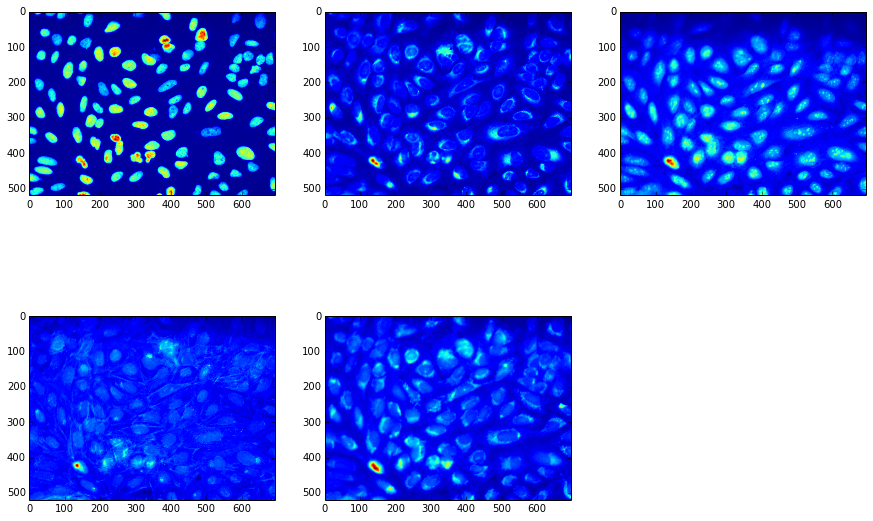

In [13]:
row = 72
showImages(row)

### Cutting the objects
The position of the objects is given by the parameters `AreaShape_Center_X` and `AreaShape_Center_Y` see also E-Mail from Daniel and http://www.cellprofiler.org/CPmanual/MeasureObjectSizeShape.html for an explanation of the individual fields.

In [14]:
x = cells['AreaShape_Center_X']
y = cells['AreaShape_Center_Y']
(max(x), max(y))

(695, 519)

**NOTE:** In the visualization (only) some lines are not shown. This is prop. due to kind of antialiasing.

In [228]:
def cutCell(x, y, d, MAL, MinAL, im_f, paint=False):
    max_x = np.shape(im_f)[1]
    max_y = np.shape(im_f)[0]
    #print('max_x={0} max_y={1}'.format(max_x,max_y))
    cx, cy = draw.circle_perimeter(x, y, 5)
    #im_f[cy, cx] = 2000
    
    xc_1 = np.cos(d)*MAL/2.0   #Determined by the Major Axis 
    yc_1 = np.sin(d)*MAL/2.0
    xc_2 = np.sin(d)*MinAL/2.0 #Determined by the Minor Axis  
    yc_2 = np.cos(d)*MinAL/2.0
    
    # Drawing the 
    cx, cy = draw.line(int(x - xc_1),int( y - yc_1),int( x + xc_1), int( y + yc_1))
    #im_f[cy, cx] = 1000
    
    xc = max(abs(xc_1), abs(xc_2))
    yc = max(abs(yc_1), abs(yc_2))
    
    #The box around the cell
    x0 = int(x - xc)
    y0 = int(y - yc)
    x1 = int(x + xc)
    y1 = int(y + yc)
    #print('i={0} x0={1} x1={2} y0={3} y1={4}'.format(i,x0,x1,y0,y1))
    if (x0 >= 0 and y0 >= 0 and x1 < max_x and y1 < max_y):
        if paint:
            im_f[y, x] = 2000
            cx, cy = draw.line(x0,y0,x0, y1)
            im_f[cy, cx] = 2000
            cx, cy = draw.line(x0,y0,x1, y0)
            im_f[cy, cx] = 2000
            cx, cy = draw.line(x1,y1,x1, y0)
            im_f[cy, cx] = 2000
            cx, cy = draw.line(x0,y1,x1, y1)
            #cx, cy = draw.line(527,314,612, 314)
            im_f[cy, cx] = 2000
            im_f[y0, x0] = 2000
            im_f[y1, x1] = 2000 
        return im_f[y0:y1,x0:x1]
    return None

### Testing of the function on a single image

Values:: Min=127.0 max=1869.0
max_x=696 max_y=520


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


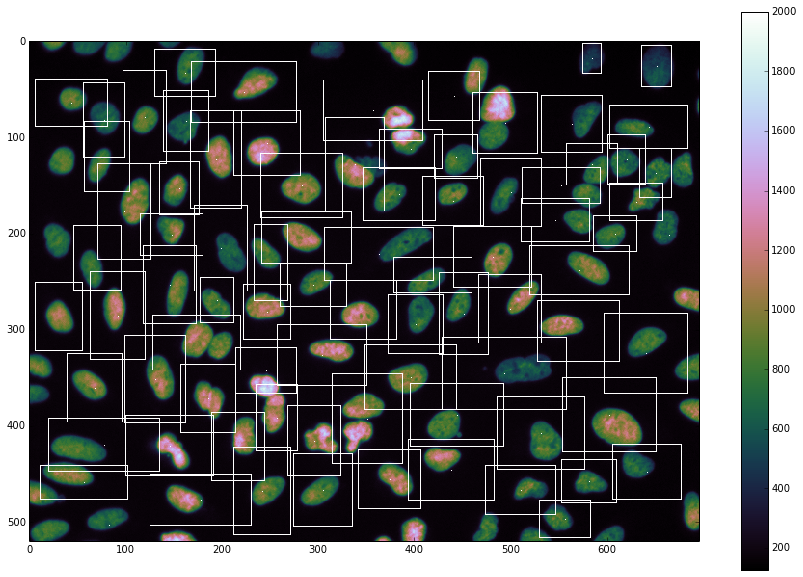

In [173]:
from skimage import data, io, draw #http://scikit-image.org/docs/stable/
import matplotlib.pyplot as plt

row = 72
img_FileName = images['FileName_Hoechst'][row]
im = Image.open('/Users/oli/datasets/Genedata/BBBC022_Profiling/' + img_FileName)
im_f = np.asarray(im, dtype='float32')
print('Values:: Min={0} max={1}'.format(np.min(im_f), np.max(im_f)))


imgCells = cells[cells['ImageNumber'] == row+1]
xs = np.asarray(imgCells['AreaShape_Center_X'])
ys = np.asarray(imgCells['AreaShape_Center_Y'])
MALs = np.asarray(imgCells['AreaShape_MajorAxisLength']) 
MinALs = np.asarray(imgCells['AreaShape_MinorAxisLength']) 
DEGs = np.asarray(imgCells['AreaShape_Orientation']) / 180.0 * np.pi
EGGs = np.asarray(imgCells['AreaShape_Eccentricity'])

max_x = np.shape(im_f)[1]
max_y = np.shape(im_f)[0]
print('max_x={0} max_y={1}'.format(max_x,max_y))

im_cut = None
for i in range(len(xs)): #range(12,13):#
    x = xs[i] #from 0 to approx 700
    y = ys[i] #from 0 to approx 500
    d = DEGs[i]
    MAL = MALs[i]
    MinAL = MinALs[i]
    im_cut_t = cutCell(x,y,d,MAL,MinAL,im_f, paint=True)
    if im_cut_t != None:
        im_cut = im_cut_t

for i in range(len(xs)):
    im_f[ys[i], xs[i]] = 2000
    
io.imshow(im_f)    

(46.215914636550892,
 476.1097823755195,
 119.78408536344911,
 529.89021762448056,
 695,
 (520, 696))

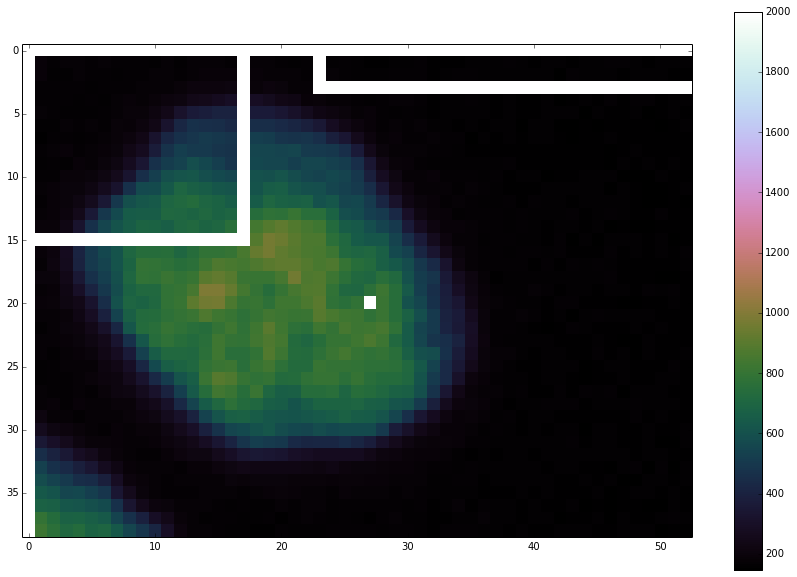

In [174]:
io.imshow(im_cut) 
x - xc, y - yc, x + xc, y + yc, np.max(xs), np.shape(im_f)

### Creating the blob
Here we create the 4 dimensional data structure (cells, channels, x,y) which we will use for the network.

In [191]:
xs = np.asarray(cells['AreaShape_Center_X'])
ys = np.asarray(cells['AreaShape_Center_Y'])
MALs = np.asarray(cells['AreaShape_MajorAxisLength']) 
MinALs = np.asarray(cells['AreaShape_MinorAxisLength']) 
DEGs = np.asarray(cells['AreaShape_Orientation']) / 180.0 * np.pi
EGGs = np.asarray(cells['AreaShape_Eccentricity'])
prefix = '/Users/oli/datasets/Genedata/BBBC022_Profiling/'
PIXELS = (48,48)

In [193]:
numCells = len(xs) #Note that we expect even less cells found in the end since cells at the border are not used
X = np.zeros((numCells,5,PIXELS[0],PIXELS[1]), dtype='float32') 
Y = np.zeros(numCells)
cell_rows = np.zeros(numCells)

In [200]:
# Scales an image to (48,48) keeping the aspect ratio constant
from skimage import transform
def rectifyAndScale(res):
    m = max(np.shape(res))
    Xs = np.ones((m,m))*np.min(res)
    off_set = (np.asarray((m, m)) - np.shape(res))/(2,2)
    x1 = off_set[0]
    x2 = m-off_set[0]
    y1 = off_set[1]
    y2 = (m-off_set[1])
    d = np.shape(res)
    Xs[x1:x1+d[0],y1:y1+d[1]] = res
    return skimage.transform.resize(Xs,PIXELS)

In [232]:
last_im_row = -1
cell_nums = 0
for row in range(4):#range(len(xs)):
    im_row = cells['ImageNumber'][row] - 1
    if (im_row != last_im_row): # New Image
        print('New Image {0}'.format(im_row))
        last_im_row = im_row
        im_Hoechst = np.asarray(Image.open(prefix + images['FileName_Hoechst'][im_row]), dtype='float32')
        im_ER = np.asarray(Image.open(prefix + images['FileName_ER'][im_row]), dtype='float32')
        im_Nucleoli = np.asarray(Image.open(prefix + images['FileName_Nucleoli'][im_row]), dtype='float32')
        im_Golgi_Actin = np.asarray(Image.open(prefix + images['FileName_Golgi_Actin'][im_row]), dtype='float32')
        im_Mito = np.asarray(Image.open(prefix + images['FileName_Mito'][im_row]), dtype='float32')
    x = xs[row] #from 0 to approx 700
    y = ys[row] #from 0 to approx 500
    d = DEGs[row]
    MAL = MALs[row]
    MinAL = MinALs[i]
    res = cutCell(x, y, d, MAL, MinAL, im_f=im_Hoechst)
    if (res != None):
        X[cell_nums,0,:,:] = rectifyAndScale(res)
        X[cell_nums,1,:,:] = rectifyAndScale(cutCell(x, y, d, MAL, MinAL, im_f=im_ER))
        X[cell_nums,2,:,:] = rectifyAndScale(cutCell(x, y, d, MAL, MinAL, im_f=im_Nucleoli))
        X[cell_nums,3,:,:] = rectifyAndScale(cutCell(x, y, d, MAL, MinAL, im_f=im_Golgi_Actin))
        X[cell_nums,4,:,:] = rectifyAndScale(cutCell(x, y, d, MAL, MinAL, im_f=im_Mito))
        Y[cell_nums] = cells['Metadata_Phenotype'][row]
        cell_rows[cell_nums] = row
        cell_nums += 1
        #io.imshow(X)
        #print(np.shape(res))

New Image 0


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:19: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [202]:
maxIdx = cell_nums - 1
print(cell_nums)

52951


In [225]:
# Note that pickle does not work in the case, since the data seems to be too large
# See: http://stackoverflow.com/questions/28503942/pickling-large-numpy-array

#import pickle
#with open('HCS_48x48.pickle', 'wb') as f:
#    pickle.dump((cell_rows[0:maxIdx],X[0:maxIdx,:,:,:],Y[0:maxIdx]), f, -1)
%ls -lh 
with open('HCS_48x48.npz', 'wb') as f:
    np.savez(f, cell_rows[0:maxIdx],X[0:maxIdx,:,:,:],Y[0:maxIdx])

total 6144
-rw-r--r--  1 oli  staff   2.6M Jul 28 18:06 DataHandling.ipynb
-rw-r--r--  1 oli  staff   414K Jul 28 18:00 HCS_48x48.pickle


In [222]:
X[maxIdx,1,:,:]
cell_rows[43423]

50372.0

In [233]:
%ls -lh 


total 3297408
-rw-r--r--  1 oli  staff   1.5M Jul 28 18:10 DataHandling.ipynb
-rw-r--r--  1 oli  staff   1.6G Jul 28 18:07 HCS_48x48.npz.gz
